In [1]:
from nets import ResNet, MLP, MLP_BN, ResNet_BN
from pipelines import losses_and_accs
from tqdm.contrib.itertools import product

inits = ["xavier", "he"]

clss = [ResNet, MLP, MLP_BN, ResNet_BN]

num_layerss = [1, 2, 5, 10, 20]

epochs = 50
lr = 0.001

In [2]:
results = {}

params = [inits, clss, num_layerss]

for init_type, cls, num_layers in product(*params):
    num_layers_param = num_layers // 2 if "ResNet" in cls.__name__ else num_layers
    results[(cls.__name__, num_layers, init_type)] = losses_and_accs(
        cls, num_layers=num_layers_param, lr=lr, epochs=epochs, init_type=init_type
    )

  0%|          | 0/40 [00:00<?, ?it/s]

### Create ckpt

In [3]:
import pickle

from datetime import datetime

uniq_run = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

filename = f"dump_{uniq_run}.pkl"

with open(filename, "wb") as file:
    pickle.dump(results, file)

### Load ready results

In [4]:
# import pickle

# with open("dump_2024-04-25_17:59:49.pkl", "rb") as f:
#     results = pickle.load(f)

In [5]:
from plot import launch_plot

launch_plot(results)

### Pruning

In [6]:
from pruning import losses_and_accs

OK = 5
TOO_MANY = 20

net, losses, accs = losses_and_accs(num_layers=TOO_MANY)

In [7]:
net.activations

[-0.007012335583567619,
 0.02186167985200882,
 -0.016626372933387756,
 -0.06758849322795868,
 0.019832400605082512,
 0.1024513989686966,
 0.012270593084394932,
 0.10830237716436386,
 0.17169193923473358,
 0.19133201241493225,
 0.2323245406150818,
 0.25902190804481506,
 0.24289974570274353,
 0.149628683924675,
 0.07214869558811188,
 -0.24159686267375946,
 -0.24294178187847137,
 -0.6975244879722595,
 -0.33310750126838684,
 -0.6537989974021912]

In [8]:
from pipelines import evaluate_model


evaluate_model(net)

0.9566

### Prune

In [9]:
net.prune_blocks(15)

evaluate_model(net)

0.1308

In [10]:
net.activations

[-0.06006386876106262,
 -0.09768974781036377,
 -0.09636735171079636,
 -0.10900764167308807,
 -0.07764813303947449]

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from pipelines import train_model

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
losses_after, accs_after = train_model(
    net,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
)

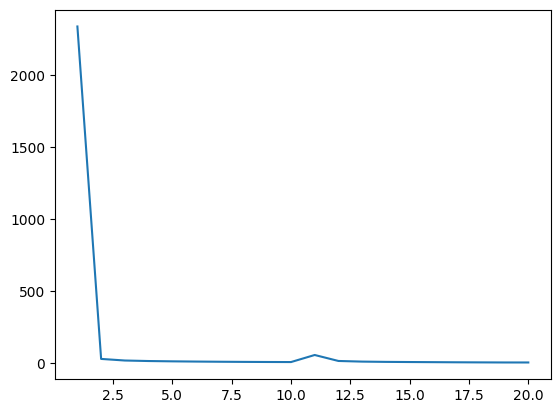

In [12]:
import matplotlib.pyplot as plt

all_losses = losses + losses_after
all_accs = accs + accs_after

x_axis = range(1, len(all_losses) + 1)

plt.plot(x_axis, all_losses)
plt.show()

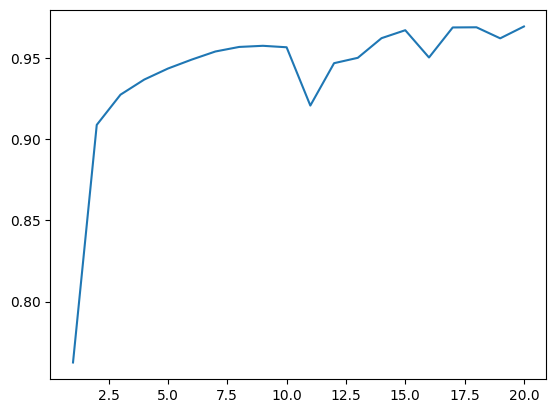

In [13]:
plt.plot(x_axis, all_accs)
plt.show()

In [14]:
from pruning import losses_and_accs

net, losses, accs = losses_and_accs(num_layers=OK)

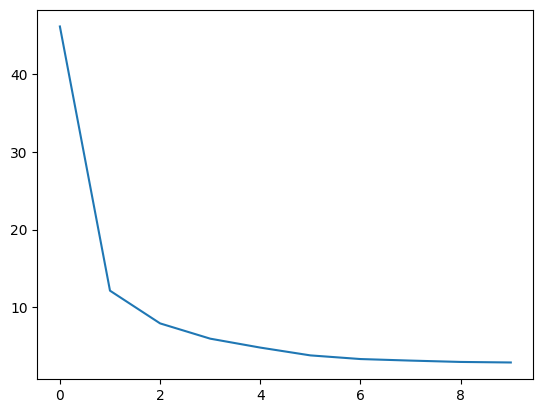

In [15]:
plt.plot(range(10), losses)
plt.show()

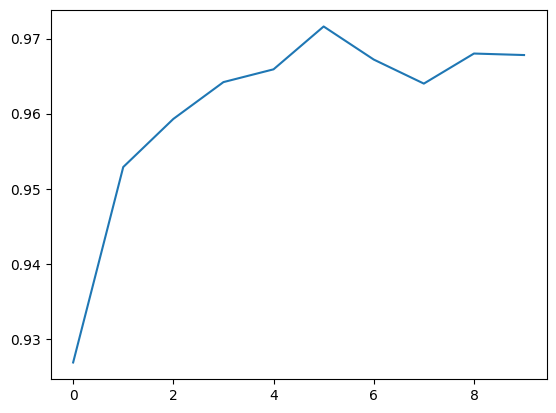

In [16]:
plt.plot(range(10), accs)
plt.show()